In [33]:
import numpy as np
import matplotlib.pyplot as plt

# NZZNT

In [120]:
def diagonalize(N, hamiltonian_function):
    k_points = 51
    k_array = np.linspace(-np.pi/a, np.pi/a, k_points)
    E_array = np.zeros((k_points, 4*N))
    
    for idx, k in enumerate(k_array):
        H = hamiltonian_function(k, N, alpha, beta, a)
        E_array[idx] = np.linalg.eigvalsh(H)
    
    return E_array

In [121]:
def make_NZZNT_hamiltonian(k, N, alpha=1.0, beta=-2.0, a=1.0):

    H = np.identity(4*N, dtype=complex) * alpha

    # Upper and lower diagonal

    for i in range(4*N):
        for j in range(4*N):
            if j == i+1 or j == i-1:
                H[i,j] = beta

    # Antidiagonal    
    for i in range(0, 2*N, 2):
        H[i, 4*N-1-i] = beta
        if i+1 < 2*N: 
            H[i+1, 4*N-2-i] = beta*np.exp(-1j*k*a)

    for i in range(4*N-1, 2*N-1, -2):
        H[i, 4*N-1-i] = beta
        if i-1 >= 2*N: 
            H[i-1, 4*N-i] = beta*np.exp(1j*k*a)

    # NZZNT

    H[0, 2*N-1] = H[2*N-1, 0] = beta
    H[2*N, 4*N-1] = H[4*N-1, 2*N] = beta
    
    return H

In [122]:
alpha = 0.0
beta = -2.8
a = 1.42

k_array = np.linspace(-np.pi/a, np.pi/a, 51)

E_Z9 = diagonalize(N=9, hamiltonian_function=make_NZZNT_hamiltonian)
E_Z10 = diagonalize(N=10, hamiltonian_function=make_NZZNT_hamiltonian)
E_Z11 = diagonalize(N=11, hamiltonian_function=make_NZZNT_hamiltonian)

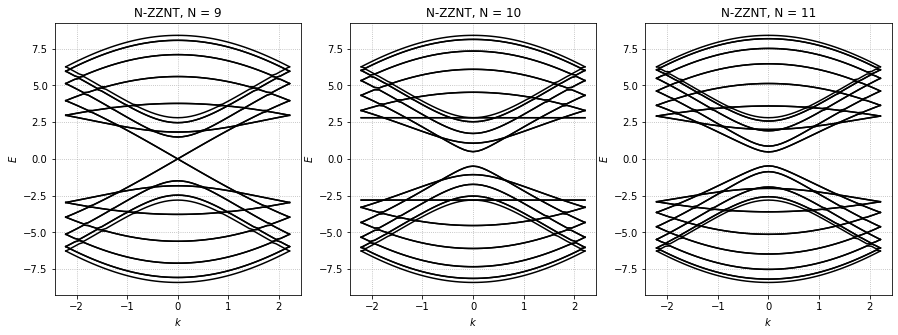

In [123]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(k_array, E_Z9, c='k')
plt.xlabel('$k$')
plt.ylabel('$E$')
plt.title(f'N-ZZNT, N = 9')
plt.grid(ls=':')

plt.subplot(1,3,2)
plt.plot(k_array, E_Z10, c='k')
plt.xlabel('$k$')
plt.ylabel('$E$')
plt.title(f'N-ZZNT, N = 10')
plt.grid(ls=':')

plt.subplot(1,3,3)
plt.plot(k_array, E_Z11, c='k')
plt.xlabel('$k$')
plt.ylabel('$E$')
plt.title(f'N-ZZNT, N = 11')
plt.grid(ls=':')

plt.show()

# DOS (Definition)

In [124]:
def get_dos(Ek, E, eta):
    dos = 0.0

    for i in range(len(E.flatten())):
        dos += eta / (eta**2 + (Ek - E.flatten()[i])**2)
    
    return dos

In [127]:
eta = 0.08
Ek = np.linspace(-9.0, 9.0, 500)

dos_z9 = get_dos(Ek, E_Z9, eta)
dos_z10 = get_dos(Ek, E_Z10, eta)
dos_z11 = get_dos(Ek, E_Z11, eta)

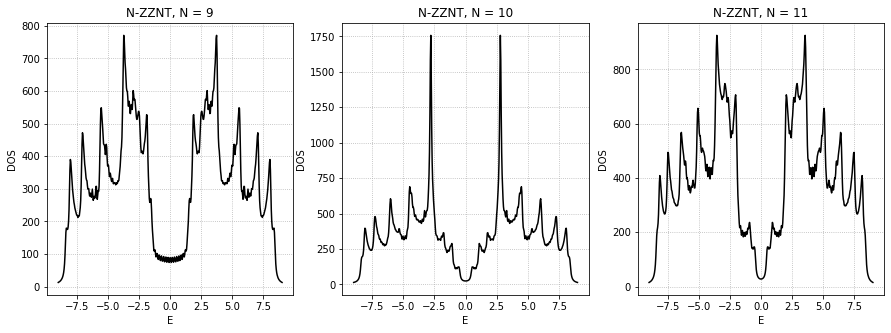

In [132]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(Ek, dos_z9, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.grid(ls=':')
plt.title(f'N-ZZNT, N = 9')

plt.subplot(1,3,2)
plt.plot(Ek, dos_z10, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.grid(ls=':')
plt.title(f'N-ZZNT, N = 10', c='k')

plt.subplot(1,3,3)
plt.plot(Ek, dos_z11, c='k')
plt.xlabel('E')
plt.ylabel('DOS')
plt.grid(ls=':')
plt.title(f'N-ZZNT, N = 11')

plt.show()

# DOS (Green's function)

In [400]:
def make_NZZNT_green_hamiltonian(N, alpha, beta, a):

    H = np.identity(4*N, dtype=complex) * alpha

    # Upper and lower diagonal

    for i in range(4*N):
        for j in range(4*N):
            if j == i+1 or j == i-1:
                H[i,j] = beta

    # Antidiagonal    
    for i in range(1, 2*N, 2):
        H[i, 4*N-1-i] = beta
        
    for i in range(2*N, 4*N, 2):
        H[i, 4*N-1-i] = beta

    # NZZNT

    H[0, 2*N-1] = H[2*N-1, 0] = beta
    H[2*N, 4*N-1] = H[4*N-1, 2*N] = beta
    
    return H

In [401]:
def make_V(N, beta):
    V = np.zeros((4*N, 4*N), dtype=complex)
    
    for i in range(0, 2*N, 2):
        V[i, 4*N-1-i] = beta
        
    for i in range(2*N+1, 4*N+1, 2):
        V[i, 4*N-1-i] = beta
    
    return V

In [405]:
alpha = 0.0
beta = -2.8
a = 1.42

eta = 1e-1

N = 10

H = make_NZZNT_green_hamiltonian(N, alpha, beta, a)
V = make_V(N, beta)

In [413]:
E_array = np.linspace(-8.0, 8.0, 201)
g_array = np.zeros((len(E_array),4*N,4*N), dtype=complex)

def G_0(E):
    return np.linalg.inv(np.identity(4*N)*(E+1j*eta) - H)

def S_n(G0, V, S):
    return G0 @ np.linalg.inv(np.identity(4*N) - G0@V@S@V.conj().T)

n_max = 100

for i in range(len(E_array)):
    G0 = G_0(E_array[i])
    SR = G0
    SL = G0
    for n in range(n_max):
        SRn = S_n(G0, V, SR)
        SLn = S_n(G0, V.conj().T, SL)
        SR = SRn
        SL = SLn
    g_array[i] = S_n(SR, V.conj().T, SL)

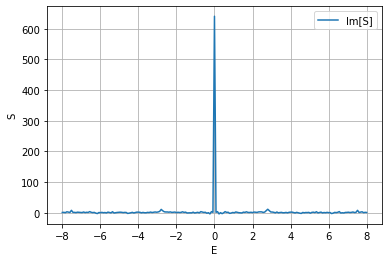

In [414]:
plt.plot(E_array, -np.trace(g_array, axis1=1, axis2=2).imag, label='Im[S]')
plt.xlabel('E')
plt.ylabel('S')
plt.legend()
plt.grid()
plt.show()